In [2]:
import numpy as np
import pandas as pd
import json
import os

## Load latest full error

In [3]:
full_err_df = pd.read_csv("Full/full_err.csv", index_col=0)

# Cross validation training

### Wrapped Cross Validation Grid Search Trainer

In [4]:
from numpy import mean, absolute
from itertools import combinations
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
from IPython.display import clear_output
import os

def run_feature_subset_cv(
    f_full, 
    input_features, 
    target_feature, 
    model, 
    model_params, 
    extra_features=[], 
    use_gpu_cv=False,
    use_feature_subsets=True, 
    refit_error='MAPE', #MAPE OR MAE
    output_folder="CV_results"
):
    
    # Prepare input and target
    X_full = f_full[input_features+extra_features]
    y = f_full[target_feature]
    groups = f_full['Name'] if use_gpu_cv else None  # Use 'Name' for GroupKFold if applicable

    # Generate feature subsets or use all features
    if use_feature_subsets:
        feature_subsets = []
        for r in range(1, len(X_full[input_features].columns) + 1):  # r = subset size (1 to len(columns))
            feature_subsets.extend(combinations(X_full[input_features].columns, r))
    else:
        feature_subsets = [input_features]  # Use all input features as one subset
    
    # Define cross-validation strategy
    cv = GroupKFold(n_splits=5) if use_gpu_cv else KFold(n_splits=10, shuffle=True, random_state=1)

    # Define scoring metrics
    scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
    scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Store results
    results = []

    print(f"Testing {len(feature_subsets)} feature subset(s)...")
    with tqdm(total=len(feature_subsets), desc="Progress", unit="subset") as pbar, \
         tqdm(total=len(feature_subsets), desc="Custom Text", unit="update") as text_pbar:
                # Iterate over feature subsets
        for features in feature_subsets:
            # Subset the input data
            X = X_full[list(features)+extra_features]

            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=model_params,
                scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},
                refit=refit_error,  # Optimize based on MAPE
                cv=cv.split(X, y, groups) if use_gpu_cv else cv,
                verbose=0,
                n_jobs=-1  # Use all available cores
            )

            # Fit GridSearchCV
            grid_search.fit(X, y)

            # Append results
            results.append({
                'features': list(features)+extra_features,
                'best_params': grid_search.best_params_,
                'best_mae': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],
                'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_]
            })
            
            pbar.set_postfix({"current_subset": str(list(features)+extra_features), "current_mae": round(results[-1]['best_mae'], 3),"current_mape": round(results[-1]['best_mape'], 3)})
            text_pbar.set_description_str(
                f"> best_mae:{round(min(results, key=lambda x: x['best_mae'])['best_mae'], 3)}\n"+
                f"> best_mape:{round(min(results, key=lambda x: x['best_mape'])['best_mape'], 3)}\n"+
                f"> best_params:{min(results, key=lambda x: x['best_mape'])['best_params']}\n"+
                f"> best_features:{min(results, key=lambda x: x['best_mape'])['features']}")
            pbar.update(1)
            text_pbar.update(1)

    # Find the best result
    best_result = min(results, key=lambda x: x['best_mape'])
    
    # Extract the model name from the pipeline
    model_name = model.regressor.steps[-1][1].__class__.__name__

    # Determine CV type for the filename
    cv_type = "GPU_CV" if use_gpu_cv else "Random_CV"

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the base filename
    base_filename = f"{model_name}_{cv_type}_results"
    output_path = os.path.join(output_folder, f"{base_filename}.json")

    # If a file with the same name exists, append a number
    counter = 1
    while os.path.exists(output_path):
        output_path = os.path.join(output_folder, f"{base_filename}_{counter}.json")
        counter += 1

    # Include best result in the JSON data
    output_data = {
        "all_results": results,
        "best_result": best_result
    }

    # Write results to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(output_data, json_file, indent=4, default=str)  # Use default=str for non-serializable data

    print(f"Results saved to {output_path}")
    
    return best_result,results


## Error Tests

In [7]:
full_err_df

,N,theta,dt,I,accumulated_error
0,100,0.2,0.000063,1,0.000000e+00
1,100,0.2,0.000063,2,-1.516100e-08
2,100,0.2,0.000063,3,-3.707700e-08
3,100,0.2,0.000063,4,-6.877790e-08
4,100,0.2,0.000063,5,-8.903680e-08
...,...,...,...,...,...
1000095,1000000,0.8,6.250000,9997,-1.413211e+05
1000096,1000000,0.8,6.250000,9998,-1.413352e+05
1000097,1000000,0.8,6.250000,9999,-1.413493e+05
1000098,1000000,0.8,6.250000,10000,-1.413635e+05


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = full_err_df[['N', 'theta', 'dt', 'I']]
y = full_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = HuberRegressor()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 100, 'theta': 0.2, 'dt': 6.25e-05, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

Mean Absolute Error: 12998.901802


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- dt
- theta


In [237]:
from sklearn.linear_model import HuberRegressor

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    # ('normalize', QuantileTransformer()),
    ('model', HuberRegressor())
])

# Wrap with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=FunctionTransformer(lambda x:x)
)

# Define hyperparameter grid
model_params = {
    'regressor__model__epsilon': [1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01],
}

# Run feature subset evaluation using Random CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=full_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model,
    model_params=model_params,
    use_feature_subsets=False,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape'])

# # Run feature subset evaluation using GPU split CV
# best_result_hr, res_hr = run_feature_subset_cv(
#     f_full=f_full,
#     input_features=input_features,
#     target_feature=target_feature,
#     model=model,
#     model_params=model_params,
#     use_feature_subsets=True,
#     use_gpu_cv=True  # Set to False to use regular KFold
# )

# # Display the best result
# print("Best feature subset:", best_result_hr['features'])
# print("Best parameters:", best_result_hr['best_params'])
# print("Best MAE:", best_result_hr['best_mae'])
# print("Best MAPE:", best_result_hr['best_mape'])


Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

KeyboardInterrupt: 

### Error dataset sampling

In [8]:
# Sample by interval
interval = 1000  # Define the interval for I
sampled_err_df = full_err_df[full_err_df['I'] % interval == 0]  # Sample rows where I is a multiple of the interval\
# sampled_err_df = sampled_err_df.query('N==1000000 and theta == 0.2')
# sampled_err_df['transformed_error'] = np.log(-sampled_err_df['accumulated_error'] + sampled_err_df['accumulated_error'].max() + 1)
print(full_err_df.shape)
print(sampled_err_df.shape)

(1000100, 5)
(1000, 5)


In [74]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures(5)),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = sampled_err_df[['N', 'theta', 'dt', 'I']]
y = sampled_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = FunctionTransformer(lambda x:x**1/10)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = base_model_poly
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 1000000, 'theta': 0.2, 'dt': 0.00625, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

Mean Absolute Error: 12052.687458
Predicted Accumulated Energy Error: -8612.771177


In [24]:
# Define transformation functions
def log_transform(y):
    """Log-transform the target variable."""
    offset = -y.min() + 1  # Shift to make all values positive
    return np.log(y + offset)

def inverse_log_transform(y_transformed):
    """Inverse log-transform the target variable."""
    offset = -sampled_err_df['transformed_error'].min() + 1
    return np.exp(y_transformed) - offset

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor, Ridge
from sklearn.preprocessing import PolynomialFeatures


# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# base_model_poly = Pipeline([
#                     ('poly', PolynomialFeatures()),   # PolynomialFeatures step
#                     ('model', HuberRegressor())                # Ridge regression step
#                 ])
# param_distributions_poly = {
#     'poly__degree': [2, 3, 4, 5],                  # Degree of polynomial features
#     'ridge__alpha': [0.1, 1, 10, 100, 1000],       # Regularization parameter for Ridge
#     'ridge__fit_intercept': [True, False],         # Whether to fit the intercept term
#     'ridge__normalize': [True, False],             # Normalize inputs
# }

# Define the model pipeline
pipeline = Pipeline(steps=[
    # ('normalize', PowerTransformer()),
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    # ('normalize', MinMaxScaler()), #BAD
    
    
    # ('model', GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)) ## BEST YET
    # ('model', SVR(C=100,epsilon=0.0001)) ## SECOND BEST AND NICE GENERALIZING!!!!
    ('poly', PolynomialFeatures()),   # PolynomialFeatures step

    ('model', Ridge())
    # ('model', HuberRegressor())

    # ('model', DecisionTreeRegressor())
    # ('model', SVR())
])

# Wrap with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
)

# Define hyperparameter grid
model_params = {
    # 'regressor__model__C': [10000,100000],
    # 'regressor__model__epsilon': [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    # 'regressor__model__kernel': ['rbf']
}

model_params = {
    'regressor__poly__degree': [2, 3, 4, 5], 
    # 'regressor__model__epsilon': [1,1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
}

# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model,
    model_params=model_params,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])



Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/Ridge_Random_CV_results_1.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 0.001, 'regressor__poly__degree': 5}
Best MAE: 1756.1405526379906
Best MAPE: 0.8949636043693834


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[input_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predict and inverse transform the predictions
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

Mean Absolute Error: 24.911457


In [54]:
print(y_test,list(y_pred))


522051     -789.933965
738072    -9184.564896
741073   -14223.242100
661065       -0.365562
412040      -13.956371
              ...     
409039       -0.020764
333032    -9902.535416
209019       -0.009837
614060       -5.213451
79006     -2366.937615
Name: accumulated_error, Length: 200, dtype: float64 [-810.2900329423506, -8626.067663678843, -14222.691431182546, -0.3581854877424601, -12.23801787403209, -2397.9081369653645, -1594.2272874232024, -46.76185073662526, -0.040438008448115535, -2397.6901785074992, -0.12004779400974315, -1943.0566589796745, -7318.115334571869, -89.30980329595815, -6035.3796893009685, -141477.47619582864, -4662.750430673194, -2157.411625956934, -1.4527635421528293, -1245.212534905422, -141858.74438834615, -1456.052867214168, -2022.2216787849525, -5290.6750913326605, -55.112975194921404, -11632.01484332887, -7.96733573058962e-05, -4377.622032698968, -0.0035021696631861595, -112824.42122777521, -42701.40041258096, -3732.184935910629, -194.562408749539, -141925.

In [67]:
y_pred = model.predict(X_test)

In [69]:
model.predict([[100000,0.8,0.00625, 10000]])

/home/home-server/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


array([-443.17583261])

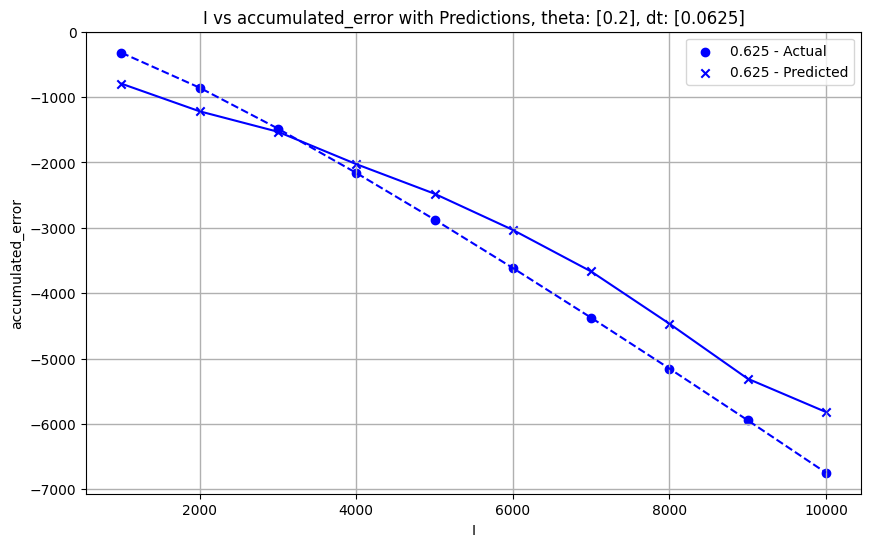

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df = sampled_err_df.copy()
# Define the filter criteria
filter_criteria = {
    'theta': [0.2],
    'N': [1000000],
    # 'I': [10000],
    'dt': [0.625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_accumulated_error'] = model.predict(df[['N', 'theta', 'dt', 'I']])

# Group by a specific feature
grouped = df.groupby('dt')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data['I'], group_data['accumulated_error'], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data['I'], group_data['accumulated_error'], linestyle='--', color=color)  # Dashed line for actual
    
    # Plot predicted values
    ax.scatter(group_data['I'], group_data['predicted_accumulated_error'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data['I'], group_data['predicted_accumulated_error'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel('I')
ax.set_ylabel('accumulated_error')
ax.set_title('I vs accumulated_error with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()